In [51]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
with open("../../../data/out/prompts_speaker_exp_Llama-3.2-1B.json", encoding="utf-8") as f:
    res = json.load(f)

In [ ]:
res_real = res["real"]  # reproduction from real speakers
res_real_plain = res_real["plain"]  # focus on plain
all_trials = []
for experiment_data in res_real_plain:
    all_trials.extend(experiment_data["trial_items"])

In [9]:
all_trials[0]

{'prompt': 'Hint: The opinions will be written in a plain text, from "strongly negative" to "strongly positive". \n\nStart!\n===========================\n\nChristian wants to discuss the housing crisis with John.\nChristian feels strongly positive about the issue.\nChristian thinks that John feels strongly positive about it, but he is not sure.\n\nChristian wants to avoid possible conflicts. What would Christian say?\n\nA: The mayor\'s decision about the housing crisis is awful.\nB: The mayor\'s decision about the housing crisis is rather bad.\nC: The mayor\'s decision about the housing crisis is okay.\nD: The mayor\'s decision about the housing crisis is decent.\nE: The mayor\'s decision about the housing crisis is great.\n\n\n===========================\n\n\nYour answer is ',
 'metadata': {'match': True,
  'conversational_goal': 'social',
  'is_positive': True,
  'response': 5},
 'prob_distr': [0.2856429152058396,
  0.14594884029104857,
  0.25356185845659707,
  0.1735633993005108,
  

# Overall Inter-rater Agreement

In [16]:
# first, inspect overall distribution of predictions
golds = np.array(
    [trial["metadata"]["response"] for trial in all_trials]
)
preds = np.array(
    [trial["pred"] for trial in all_trials]
)

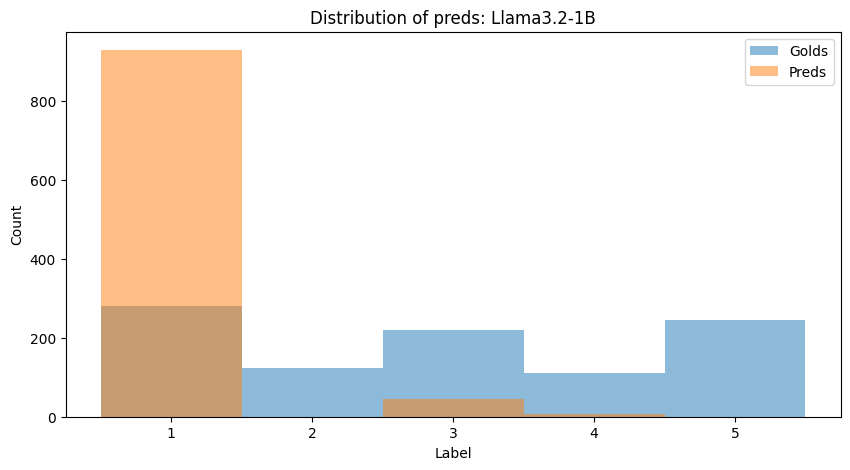

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(golds, bins=np.arange(1, 7)-0.5, alpha=0.5, label="Golds")
plt.hist(preds, bins=np.arange(1, 7)-0.5, alpha=0.5, label="Preds")
plt.xticks(range(1, 6))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of preds: Llama3.2-1B")
plt.legend()
plt.savefig("llama3.2-1B_distribution.png")
plt.show()

In [18]:
kappa_llama = cohen_kappa_score(golds, preds)
kappa_llama

0.005605428292699943

# Collect Indirect Speech

In [22]:
for trial in all_trials:
    expected = 5 if trial["metadata"]["is_positive"] else 1
    trial["is_indirect"] = trial["pred"] != expected

In [23]:
all_trials[0]

{'prompt': 'Hint: The opinions will be written in a plain text, from "strongly negative" to "strongly positive". \n\nStart!\n===========================\n\nChristian wants to discuss the housing crisis with John.\nChristian feels strongly positive about the issue.\nChristian thinks that John feels strongly positive about it, but he is not sure.\n\nChristian wants to avoid possible conflicts. What would Christian say?\n\nA: The mayor\'s decision about the housing crisis is awful.\nB: The mayor\'s decision about the housing crisis is rather bad.\nC: The mayor\'s decision about the housing crisis is okay.\nD: The mayor\'s decision about the housing crisis is decent.\nE: The mayor\'s decision about the housing crisis is great.\n\n\n===========================\n\n\nYour answer is ',
 'metadata': {'match': True,
  'conversational_goal': 'social',
  'is_positive': True,
  'response': 5},
 'prob_distr': [0.2856429152058396,
  0.14594884029104857,
  0.25356185845659707,
  0.1735633993005108,
  

# Aggregate by Match

/var/folders/_8/wwb5csy9605g6rl6wf4lcfch0000gr/T/ipykernel_44276/2161252414.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


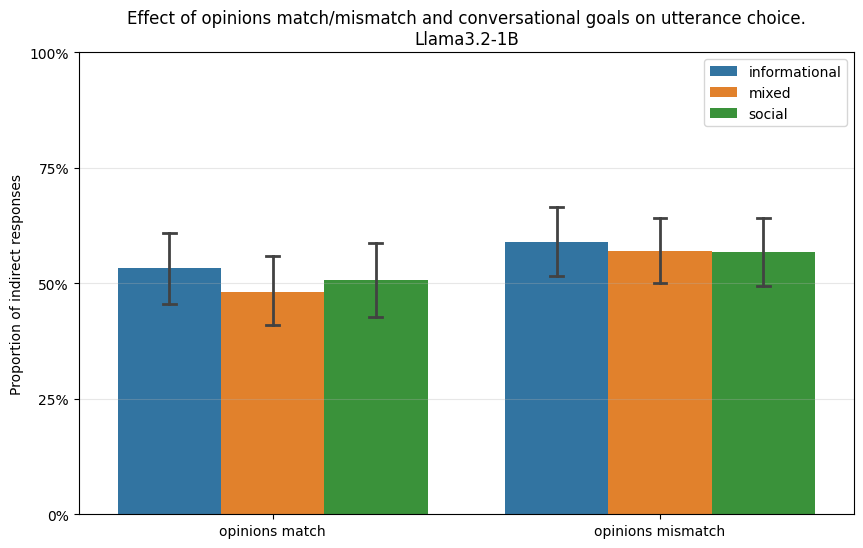

In [64]:
indirect_df = pd.DataFrame([
    {
        "match": "opinions match" if trial["metadata"]["match"] else "opinions mismatch",
        "polarity": "strongly negative" if not trial["metadata"]["is_positive"] else "strongly positive",
        "is_indirect": int(trial["is_indirect"]),
        "goal": trial["metadata"]["conversational_goal"],
    }
    for trial in all_trials
])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=indirect_df,
    x="match",
    y="is_indirect",
    hue="goal",
    order=["opinions match", "opinions mismatch"],
    hue_order=["informational", "mixed", "social"],
    errorbar="ci",
    errwidth=2,
    capsize=0.1,
    ax=ax
)

ax.set_title("Effect of opinions match/mismatch and conversational goals on utterance choice.\nLlama3.2-1B")
ax.set_ylabel("Proportion of indirect responses")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.legend(title="")
ax.grid(axis="y", alpha=0.3, zorder=0)

plt.savefig("llama3.2-1B_match.png")
plt.show()

In [ ]:
results = []
goals = indirect_df["goal"].unique()
for goal in goals:

    # aggregate data
    goal_data = indirect_df[indirect_df["goal"] == goal]
    match_data = goal_data[goal_data["match"] == "opinions match"]["is_indirect"]
    mismatch_data = goal_data[goal_data["match"] == "opinions mismatch"]["is_indirect"]
    
    # calculate proportions
    n_match = len(match_data)
    n_mismatch = len(mismatch_data)
    n_indirect_match = match_data.sum()
    n_indirect_mismatch = mismatch_data.sum()
    n_indirect_prop_match =  n_indirect_match / n_match
    n_indirect_prop_mismatch = n_indirect_mismatch / n_mismatch

    # two-proportion z-test
    count = np.array([n_indirect_match, n_indirect_mismatch])
    nobs = np.array([n_match, n_mismatch])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal": goal,
        "total number of responses, opinions match": n_indirect_match,
        "proportion of indirect responses, opinions match": n_indirect_prop_match,
        "total number of responses, opinions mismatch": n_indirect_mismatch,
        "proportion of indirect responses, opinions mismatch": n_indirect_prop_mismatch,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [68]:
match_summary_df = pd.DataFrame(results)
print(match_summary_df.to_string(index=False))

conversational goal  total number of responses, opinions match  proportion of indirect responses, opinions match  total number of responses, opinions mismatch  proportion of indirect responses, opinions mismatch    z-stat  p-value
             social                                         76                                          0.506667                                            92                                             0.567901 -1.084030 0.278352
              mixed                                         74                                          0.480519                                           105                                             0.570652 -1.653426 0.098244
      informational                                         90                                          0.532544                                            95                                             0.590062 -1.052314 0.292656


# Aggregate by Speaker's Opinion

/var/folders/_8/wwb5csy9605g6rl6wf4lcfch0000gr/T/ipykernel_44276/2281265513.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


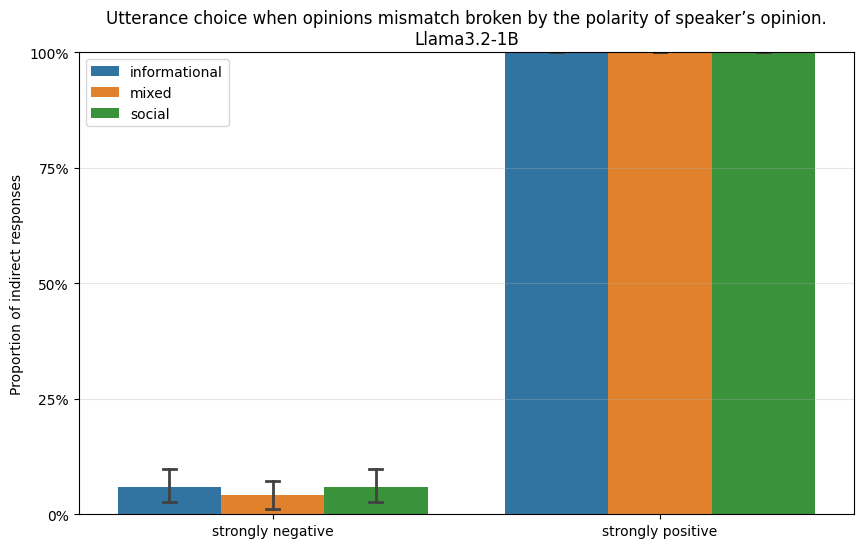

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=indirect_df,
    x="polarity",
    y="is_indirect",
    hue="goal",
    order=["strongly negative", "strongly positive"],
    hue_order=["informational", "mixed", "social"],
    errorbar="ci",
    errwidth=2,
    capsize=0.1,
    ax=ax
)

ax.set_title("Utterance choice when opinions mismatch broken by the polarity of speaker’s opinion.\nLlama3.2-1B")
ax.set_ylabel("Proportion of indirect responses")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.legend(title="")
ax.grid(axis="y", alpha=0.3, zorder=0)

plt.savefig("llama3.2-1B_polarity.png")
plt.show()

In [74]:
results = []
for goal in goals:

    # aggregate data
    goal_data = indirect_df[indirect_df["goal"] == goal]
    negative_data = goal_data[goal_data["polarity"] == "strongly negative"]["is_indirect"]
    positive_data = goal_data[goal_data["polarity"] == "strongly positive"]["is_indirect"]

    # calculate proportions
    n_negative = len(negative_data)
    n_positive = len(positive_data)
    n_indirect_negative = negative_data.sum()
    n_indirect_positive = positive_data.sum()
    n_indirect_prop_negative =  n_indirect_negative / n_negative
    n_indirect_prop_positive = n_indirect_positive / n_positive

    # two-proportion z-test
    count = np.array([n_indirect_negative, n_indirect_positive])
    nobs = np.array([n_negative, n_positive])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal": goal,
        "total number of responses, strongly negative": n_indirect_negative,
        "proportion of indirect responses, strongly negative": n_indirect_prop_negative,
        "total number of responses, strongly positive": n_indirect_positive,
        "proportion of indirect responses, strongly positive": n_indirect_prop_positive,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [71]:
polarity_summary_df = pd.DataFrame(results)
print(polarity_summary_df.to_string(index=False))

conversational goal  total number of responses, opinions match  proportion of indirect responses, opinions match  total number of responses, opinions mismatch  proportion of indirect responses, opinions mismatch     z-stat      p-value
             social                                          9                                          0.058824                                           159                                                  1.0 -16.670812 2.136727e-62
              mixed                                          7                                          0.042169                                           172                                                  1.0 -17.637644 1.266313e-69
      informational                                          9                                          0.058442                                           176                                                  1.0 -17.192977 2.997388e-66


# Summary

In [75]:
summary = f"""\
Overall Cohen's kappa between golds and preds: {kappa_llama:.3f}


Z-scores and p-values for the effect of opinions match/mismatch on the proportion of indirect responses, by conversational goal:
{match_summary_df.to_string(index=False)}


Z-scores and p-values for the effect of polarity (strongly negative vs. strongly positive) on the proportion of indirect responses, by conversational goal:
{polarity_summary_df.to_string(index=False)}
"""

with open("llama3.2-1B_summary.txt", "w", encoding="utf-8") as f:
    f.write(summary)

print(summary)

Overall Cohen's kappa between golds and preds: 0.006


Z-scores and p-values for the effect of opinions match/mismatch on the proportion of indirect responses, by conversational goal:
conversational goal  total number of responses, opinions match  proportion of indirect responses, opinions match  total number of responses, opinions mismatch  proportion of indirect responses, opinions mismatch    z-stat  p-value
             social                                         76                                          0.506667                                            92                                             0.567901 -1.084030 0.278352
              mixed                                         74                                          0.480519                                           105                                             0.570652 -1.653426 0.098244
      informational                                         90                                          0.532544           